<b><center> AS - Segmenting and Clustering Neighborhoods - TORONTO <b><center>

<b><center>(III) Cluster Analysis of Toronto Neighborhoods<b><center>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pytest-doctestplus==0.1.3=py36_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::pytest-arraydiff==0.2=py36h39e3cac_0
  - defaults/linux-64::hdmedians==0.13=py36h035aef0_0
  - defaults/linux-64::scikit-learn==0.19.2=py37h4989274_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::blaze==0.11.3=py36_0
  - https://repo.anaconda.com/pkgs/free/linux-64::pymc==2.3.6=np111py36_2
  - defaults/linux-64::pandasql==0.7.3=py36_1
  - defaults/linux-64::mkl_random==1.0.1=py36h4414c95_1
  - defaults/linux-64::statsmodels==0.9.0=py36h035aef0_0
  - defaults/linux-64::odo==0.5.1=py36_0
  - defaults/linux-64::pandas==0.22.0=py36hf484d3e_0
  - defaults/linux-64::dask==0.19.3=py36_0
  - defaults/linux-64::scipy==1.1.0=py36hd20e5f9_0
  - defaults/linux-64::seaborn==0.9.0=py36_0
  - defaults/linux-64:

vincent-0.4.4        | 28 KB     | ##################################### | 100% 
altair-4.1.0         | 614 KB    | ##################################### | 100% 
folium-0.5.0         | 45 KB     | ##################################### | 100% 
branca-0.4.0         | 26 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Libraries imported.


In [2]:
#scraping wikipedia list of TORONTO postal codes using pandas

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_postal_codes_TORONTO = pd.read_html(url, header=0)[0]

# Rename Postal Code column
df_postal_codes_TORONTO = df_postal_codes_TORONTO.rename(columns={'Postal code': 'PostalCode'})

# Filter out boroughs equal to 'Not assigned'
df_postal_codes_TORONTO = df_postal_codes_TORONTO[df_postal_codes_TORONTO['Borough'] != 'Not assigned']

# Replace / with comma in Neighborhood column
df_postal_codes_TORONTO['Neighborhood'] = df_postal_codes_TORONTO['Neighborhood'].str.replace('/',',')

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
df_postal_codes_TORONTO.Neighborhood[df_postal_codes_TORONTO.Neighborhood == 'Not assigned'] = df_postal_codes_TORONTO.Borough

# Showing entire pandas dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows
df_postal_codes_TORONTO.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [3]:
df_postal_codes_TORONTO.shape

(103, 3)

<b><center>Adding GPS coordinates to dataframe<b><center>

In [4]:
# Read the csv file directly from the url provided
Toronto_GPS_Coordinates = pd.read_csv('http://cocl.us/Geospatial_data')

# Rename Postal Code column
Toronto_GPS_Coordinates = Toronto_GPS_Coordinates.rename(columns={'Postal Code': 'PostalCode'})

Toronto_GPS_Coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# Toronto_GPS_Coordinates matches number of rows from df_postal_codes_TORONTO
Toronto_GPS_Coordinates.shape

(103, 3)

In [139]:
# left outer join on 'PostalCode' (please make sure columns have the exact same name) to add GPS coordinates to 'df_postal_codes_TORONTO' 
df_postal_codes_TORONTO_GPS = pd.merge(df_postal_codes_TORONTO, Toronto_GPS_Coordinates, on='PostalCode', how='left')
df_postal_codes_TORONTO_GPS
# all postal codes appear with GPS coordinates

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


<b><center> Define Foursquare Credentials and Version<b><center>

In [11]:
# @hidden_cell
# Based on New York cluster notebook created by Alex Aklson and Polong Lin

CLIENT_ID = 'SANITIZED' # your Foursquare ID
CLIENT_SECRET = 'SANITIZED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

<b><center>Function to extract VENUES data for all the neighborhoods in TORONTO <b><center>

In [12]:
# Based on New York cluster notebook created by Alex Aklson and Polong Lin

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<b><center>Run the above function on each neighborhood and create a new dataframe called TORONTO_venues.<b><center>

In [14]:
# Run function
TORONTO_venues = getNearbyVenues(names=df_postal_codes_TORONTO_GPS['Neighborhood'],
                                   latitudes=df_postal_codes_TORONTO_GPS['Latitude'],
                                   longitudes=df_postal_codes_TORONTO_GPS['Longitude'])
                                  

Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Queen's Park , Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills
Parkview Hill , Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
East Toronto
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village
Do

In [15]:
#Reviewing output
print(TORONTO_venues.shape)
TORONTO_venues.head()

(2172, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [16]:
#  venues count per neighborhood
TORONTO_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood , Long Branch",10,10,10,10,10,10
"Bathurst Manor , Wilson Heights , Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",28,28,28,28,28,28
Berczy Park,56,56,56,56,56,56
"Birch Cliff , Cliffside West",4,4,4,4,4,4
"Brockton , Parkdale Village , Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,18,18,18,18,18,18


<b><center>Count unique VENUE categories<b><center>

In [17]:
print('There are {} unique VENUE categories.'.format(len(TORONTO_venues['Venue Category'].unique())))

There are 273 unique VENUE categories.


<b><center>TORONTO_venues one hot encoding<b><center>

In [18]:
# one hot encoding
TORONTO_onehot = pd.get_dummies(TORONTO_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
TORONTO_onehot['Neighborhood'] = TORONTO_venues['Neighborhood'] 

# move neighborhood column to the first column
TORONTO_onehot = TORONTO_onehot[ ['Neighborhood'] + [ col for col in TORONTO_onehot.columns if col != 'Neighborhood' ] ]

TORONTO_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
TORONTO_onehot.shape

(2172, 273)

<b><center> Group rows by neighborhood and by taking the mean of the frequency of occurrence for each category<b><center>

In [22]:
TORONTO_grouped = TORONTO_onehot.groupby('Neighborhood').mean().reset_index()
TORONTO_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.

In [23]:
# TORONTO Grouped shape
TORONTO_grouped.shape

(96, 273)

<b><center>Function to sort the venues in descending order<b><center>

In [24]:
# Function to sort the venues in descending order
# Based on New York cluster notebook created by Alex Aklson and Polong Lin
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<b><center>Create new dataframe to display the top 10 venues for each neighborhood in TORONTO <b><center>

In [132]:
# create the new dataframe and display the top 10 venues for each neighborhood
# Based on New York cluster notebook created by Alex Aklson and Polong Lin

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = TORONTO_grouped['Neighborhood']

for ind in np.arange(TORONTO_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TORONTO_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood , Long Branch",Pizza Place,Gym,Sandwich Place,Dance Studio,Pub,Pool,Skating Rink,Pharmacy,Coffee Shop,Deli / Bodega
2,"Bathurst Manor , Wilson Heights , Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Pharmacy,Sushi Restaurant,Deli / Bodega,Diner,Restaurant,Fried Chicken Joint,Ice Cream Shop
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park , Lawrence Manor East",Italian Restaurant,Thai Restaurant,Restaurant,Coffee Shop,Sandwich Place,Juice Bar,Japanese Restaurant,Fast Food Restaurant,Indian Restaurant,Pub


In [133]:
neighborhoods_venues_sorted.shape

(96, 11)

<b><center>Run k-means to cluster the neighborhood into clusters: optimized with elbow method<b><center>

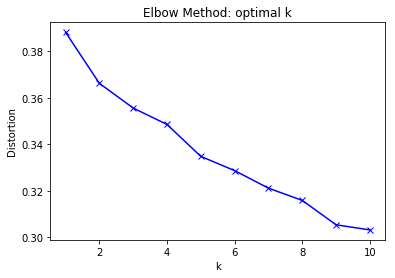

In [101]:
# k means: determine k with elbow method - Based on source: https://pythonprogramminglanguage.com/kmeans-elbow-method/
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
TORONTO_grouped_clustering = TORONTO_grouped.drop('Neighborhood', 1)

# run k-means clustering
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(TORONTO_grouped_clustering)
    kmeanModel.fit(TORONTO_grouped_clustering)
    distortions.append(sum(np.min(cdist(TORONTO_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / TORONTO_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method: optimal k')
plt.show()

<b><center>k=7 or k=9 seem like good values<b><center>

In [134]:
# set number of clusters
kclusters = 7

TORONTO_grouped_clustering = TORONTO_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TORONTO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 5, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 3, 4], dtype=int32)

In [135]:
kmeans.labels_.shape

(96,)

In [136]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_TORONTO_GPS = df_postal_codes_TORONTO_GPS.drop('PostalCode', 1)

df_TORONTO_GPS.shape

(103, 4)

In [137]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# TORONTO_merged = TORONTO_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
TORONTO_merged = pd.merge(df_postal_codes_TORONTO_GPS, neighborhoods_venues_sorted, on='Neighborhood', how='inner')

# Dropped NaN rows
#TORONTO_merged.dropna() 

TORONTO_merged.shape

(101, 16)

In [138]:
TORONTO_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Coffee Shop,Pizza Place,Intersection,Hockey Arena,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Café,Mexican Restaurant,Event Space,Shoe Store,Restaurant
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Accessories Store,Event Space,Boutique,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Doner Restaurant,Discount Store
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Diner,Sandwich Place,Mexican Restaurant,Juice Bar,Hobby Shop,Fried Chicken Joint,Distribution Center,Discount Store,Creperie
5,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,0,Fast Food Restaurant,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
6,M3B,North York,Don Mills,43.745906,-79.352188,0,Gym,Beer Store,Japanese Restaurant,Café,Restaurant,Coffee Shop,Concert Hall,Clothing Store,Italian Restaurant,Bike Shop
7,M3C,North York,Don Mills,43.725900,-79.340923,0,Gym,Beer Store,Japanese Restaurant,Café,Restaurant,Coffee Shop,Concert Hall,Clothing Store,Italian Restaurant,Bike Shop
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937,0,Pizza Place,Fast Food Restaurant,Intersection,Athletics & Sports,Bus Line,Gastropub,Bank,Pharmacy,Pet Store,Gym / Fitness Center
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Café,Bookstore,Electronics Store


<b><center>Visualize resulting clusters<b><center>

In [130]:
# Based on New York cluster notebook created by Alex Aklson and Polong Lin
# create map
map_clusters = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(TORONTO_merged['Latitude'], TORONTO_merged['Longitude'], TORONTO_merged['Neighborhood'], TORONTO_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b><center>Examine Clusters<b><center>

In [131]:
# CLUSTER 0: socialize! large variety of venues available!
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 0, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Portuguese Restaurant,Coffee Shop,Pizza Place,Intersection,Hockey Arena,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,"Regent Park , Harbourfront",Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Café,Mexican Restaurant,Event Space,Shoe Store,Restaurant
3,"Lawrence Manor , Lawrence Heights",Clothing Store,Furniture / Home Store,Accessories Store,Event Space,Boutique,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Doner Restaurant,Discount Store
4,"Queen's Park , Ontario Provincial Government",Coffee Shop,Diner,Sandwich Place,Mexican Restaurant,Juice Bar,Hobby Shop,Fried Chicken Joint,Distribution Center,Discount Store,Creperie
5,"Malvern , Rouge",Fast Food Restaurant,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
6,Don Mills,Gym,Beer Store,Japanese Restaurant,Café,Restaurant,Coffee Shop,Concert Hall,Clothing Store,Italian Restaurant,Bike Shop
7,Don Mills,Gym,Beer Store,Japanese Restaurant,Café,Restaurant,Coffee Shop,Concert Hall,Clothing Store,Italian Restaurant,Bike Shop
8,"Parkview Hill , Woodbine Gardens",Pizza Place,Fast Food Restaurant,Intersection,Athletics & Sports,Bus Line,Gastropub,Bank,Pharmacy,Pet Store,Gym / Fitness Center
9,"Garden District, Ryerson",Coffee Shop,Clothing Store,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Café,Bookstore,Electronics Store
10,Glencairn,Park,Pizza Place,Pub,Japanese Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [140]:
# CLUSTER 1: Take it easy in North York (I)
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 1, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,North York,1,Home Service,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Department Store


In [142]:
# CLUSTER 2: I love parks and dogs!
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 2, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Park,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
20,York,2,Park,Market,Women's Store,Golf Course,Ethiopian Restaurant,Gourmet Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
61,Central Toronto,2,Park,Bus Line,Swim School,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
64,York,2,Park,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
90,Downtown Toronto,2,Park,Playground,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
96,Etobicoke,2,Park,River,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space


In [143]:
# CLUSTER 3: Take it easy in North York (II)
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 3, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,North York,3,Cafeteria,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Dessert Shop


In [144]:
# CLUSTER 4: love my park, convenience stores, empanadas and eastern european food
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 4, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,East York,4,Park,Coffee Shop,Convenience Store,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
66,North York,4,Park,Bank,Convenience Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop,Donut Shop


In [145]:
# CLUSTER 5: Scarborough
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 5, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Scarborough,5,Playground,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
84,Scarborough,5,Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [146]:
# CLUSTER 6: Central Toronto
TORONTO_merged.loc[TORONTO_merged['Cluster Labels'] == 6, TORONTO_merged.columns[[1] + list(range(5, TORONTO_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
82,Central Toronto,6,Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,College Gym


<b><center>END OF NOTEBOOK<b><center>